# LIBRARIES #


In [1]:
import os
import mne
import antropy as ant
import pandas as pd
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report, get_entities_from_fname
import scipy.signal as signal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import bids
from mne.datasets.eegbci import standardize

 #### Bandpower function by R.Vallat: Adapted from yasa.bandpower() to provide bandpower approximation from PSD array

In [2]:
def bandpower(data, sf, band, method='multitaper_average', window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'multitaper' or 'multitaper_average'. Default is 'multitaper_average'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    band = np.asarray(band)
    low, high = band

    # Compute PSD using multitaper average psd vectors over all epochs, or return the psd vector for each epoch
    if method == 'multitaper_average':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True, low_bias = True,
                                          normalization='full', verbose=0)
        psds_mean = psd.mean(0)
        psd = psds_mean

    elif method == 'multitaper':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True, low_bias = True,
                                          normalization='full', verbose=0)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

## DATASETS

#### Medellin

In [2]:
epochs = mne.read_epochs('D:/EEGs/PhD_datasets/BIDS/california/derivatives/sovaharmony/sub-hc1/ses-hc/eeg/sub-hc1_ses-hc_task-rest_desc-reject_eeg.fif', preload=True)


C:\Users\acer\AppData\Local\Temp/ipykernel_17060/1883953319.py:1: RuntimeWarning: This filename (D:/EEGs/PhD_datasets/BIDS/california/derivatives/sovaharmony/sub-hc1/ses-hc/eeg/sub-hc1_ses-hc_task-rest_desc-reject_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs('D:/EEGs/PhD_datasets/BIDS/california/derivatives/sovaharmony/sub-hc1/ses-hc/eeg/sub-hc1_ses-hc_task-rest_desc-reject_eeg.fif', preload=True)


Reading D:\EEGs\PhD_datasets\BIDS\california\derivatives\sovaharmony\sub-hc1\ses-hc\eeg\sub-hc1_ses-hc_task-rest_desc-reject_eeg.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    4998.05 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated


In [5]:
epochs.get_data()

array([[[-1.27521992e-06, -1.57434840e-06, -1.92928201e-06, ...,
          1.29089869e-06,  1.73549984e-06,  2.25067834e-06],
        [-1.63150764e-06, -2.21016194e-06, -2.90847811e-06, ...,
         -2.44905345e-06, -1.66939174e-06, -8.41309827e-07],
        [ 1.82456722e-06,  2.28355384e-06,  2.53251324e-06, ...,
         -3.74226988e-06, -2.46465925e-06, -1.51245331e-06],
        ...,
        [-2.78461289e-06, -2.51969709e-06, -2.36020242e-06, ...,
         -1.90946125e-07,  2.20459796e-07,  8.20234902e-07],
        [ 2.85111037e-06,  2.94479287e-06,  2.32467278e-06, ...,
          2.30978526e-06,  1.37475831e-06,  3.74647954e-07],
        [ 1.36264453e-06,  1.70678663e-06,  1.82113183e-06, ...,
         -4.17024523e-07,  2.31128539e-07,  1.13873875e-06]],

       [[ 2.64315941e-06,  2.77536151e-06,  2.60698744e-06, ...,
         -6.17746628e-06, -4.20060951e-06, -1.93107667e-06],
        [-1.50483885e-07,  3.11557500e-07,  5.72575232e-07, ...,
         -2.58477758e-06, -1.69257487e

    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\acer\AppData\Local\Temp/ipykernel_3232/1813318170.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd(fmax = 100)


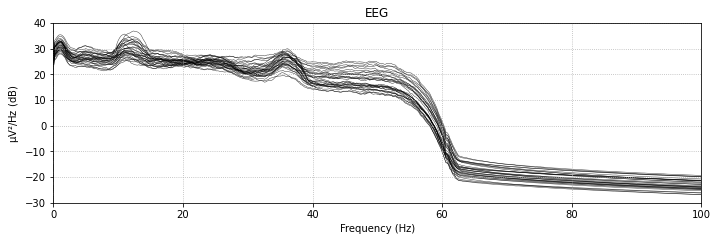

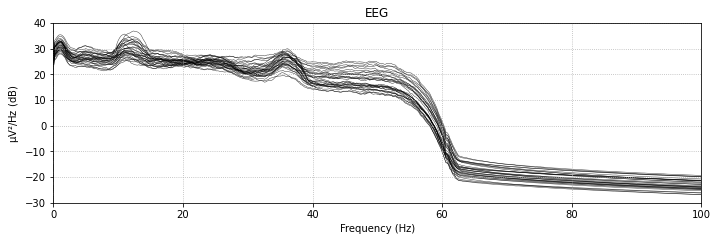

In [20]:
epochs.plot_psd(fmax = 100)

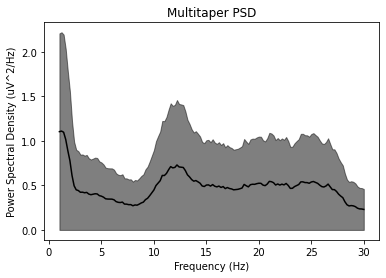

In [11]:
f, ax = plt.subplots()
psds, freqs = mne.time_frequency.psd_array_multitaper(epochs.get_data()[:,2,:]*1e6, fmin=1, fmax=30,  sfreq = epochs.info["sfreq"] , bandwidth=2, adaptive=True, normalization='full', verbose=0)
psds_mean = psds.mean(0)
psds_std = psds.mean(0)

ax.plot(freqs, psds_mean, color='k')
ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                color='k', alpha=.5)
ax.set(title='Multitaper PSD', xlabel='Frequency (Hz)',
       ylabel='Power Spectral Density (uV^2/Hz)')
plt.show()

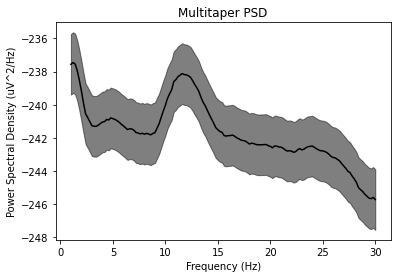

In [29]:
f, ax = plt.subplots()
psds, freqs = mne.time_frequency.psd_array_multitaper(epochs.get_data()[:,:,:]/1e06, fmin=1, fmax=30,  sfreq = epochs.info["sfreq"] , bandwidth=2, adaptive=True, normalization='full', verbose=0)
psds = 10 * np.log10(psds)  # convert to dB
psds_mean = psds.mean(0).mean(0)
psds_std = psds_mean.std(0)

ax.plot(freqs, psds_mean, color='k')
ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                color='k', alpha=.5)
ax.set(title='Multitaper PSD', xlabel='Frequency (Hz)',
       ylabel='Power Spectral Density (uV^2/Hz)')
plt.show()

In [15]:
antioquia={
'layout':{'extension':'.fif', 'suffix':'eeg', 'return_type':'filename'},
    'ch_names':['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'O1', 'OZ', 'O2'],
    'path':"D:/EEGs/PhD_datasets/BIDS/antioquia/"
}

#Path of the BIDS folder
bids_root = "D:/EEGs/PhD_datasets/BIDS/antioquia/"
#Seleccionar solo EEG
datatype = 'eeg'
suffix = 'eeg'

#Tarea
task = 'rest' 

DATASET=antioquia #SI SE CAMBIA POR CALIFORNIA, SÍ SIRVE LA LINEA DE ABAJO

layoutd = DATASET.get('layout', None)

layout = bids.BIDSLayout(DATASET.get('path', None), derivatives=True)
eegs = layout.get(**layoutd)
eegs = [k for k in eegs if 'desc-reject' in k]

print(len(eegs), eegs)

72 ['D:\\EEGs\\PhD_datasets\\BIDS\\antioquia\\derivatives\\sovaharmony\\sub-001\\eeg\\sub-001_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\antioquia\\derivatives\\sovaharmony\\sub-002\\eeg\\sub-002_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\antioquia\\derivatives\\sovaharmony\\sub-003\\eeg\\sub-003_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\antioquia\\derivatives\\sovaharmony\\sub-004\\eeg\\sub-004_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\antioquia\\derivatives\\sovaharmony\\sub-005\\eeg\\sub-005_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\antioquia\\derivatives\\sovaharmony\\sub-006\\eeg\\sub-006_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\antioquia\\derivatives\\sovaharmony\\sub-007\\eeg\\sub-007_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\antioquia\\derivatives\\sovaharmony\\sub-008\\eeg\\sub-008_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datas

FOR FDA - PSD AND BAND POWER CALCULATED IN EACH 5-SECONDS EPOCHS WITH MULTITAPER (2 Hz taper width)

In [10]:
%%capture
dict_list = []
for eeg_file in eegs: #read and preload dataset
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    bids_path = BIDSPath(subject=subject, session=session, task=task, root=bids_root, datatype='eeg')

    data_preload = {
        "preload": True
    }
    epochs = mne.read_epochs(eeg_file, preload = True)
    standardize(epochs) #standardize ch_names
    epochs = epochs.filter(l_freq=1, h_freq=30) #bandpassing 1-30Hz
    downsample = 500 #downsampling to 500Hz
    epochs.resample(downsample)
    sf = downsample
    epochs_c = mne.concatenate_epochs(epochs_list = [epochs[:][range(43)]], add_offset=False, on_mismatch='raise', verbose=None)
    epochs = epochs_c    
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    nepochs,nchannels,npoints = epochs._data.shape
    correct_channels = epochs.info['ch_names']
    epochs.reorder_channels(correct_channels)
    channels = epochs.info['ch_names']
    for ch,ch_label in enumerate(channels):
        for ep in range(nepochs):
            features = {}
            features['center'] = 'medellin'
            features['subject'] = subject
            features['channel'] = ch_label
            features['epoch'] = ep
            features['delta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [1, 4], 'multitaper', relative=True)
            features['theta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [4, 8], 'multitaper', relative=True)
            features['alpha'] = bandpower(epochs.get_data()[ep,ch,:], sf, [8, 13], 'multitaper', relative=True)
            features['beta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [13, 30], 'multitaper', relative=True)
            features['pre_alpha'] = bandpower(epochs.get_data()[ep,ch,:], sf, [5.5, 8], 'multitaper', relative=True)
            features['slow_theta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [4, 5.5], 'multitaper', relative=True)
            features['alpha1'] = bandpower(epochs.get_data()[ep,ch,:], sf, [8.5, 10.5], 'multitaper', relative=True)
            features['alpha2'] = bandpower(epochs.get_data()[ep,ch,:], sf, [10.5, 12.5], 'multitaper', relative=True)
#            features['beta1'] = bandpower(epochs.get_data()[ep,ch,:], sf, [12.5, 18.5], 'multitaper', relative=True)
#            features['beta2'] = bandpower(epochs.get_data()[ep,ch,:], sf, [18.5, 21], 'multitaper', relative=True)
#            features['beta3'] = bandpower(epochs.get_data()[ep,ch,:], sf, [21, 30], 'multitaper', relative=True)
            features['alpha_theta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [8, 13], 'multitaper', relative=True) / bandpower(epochs.get_data()[ep,ch,:], sf, [4, 8], 'multitaper', relative=True)
            dict_list.append(features)
print('SPECTRAL METRICS FOR 5-SECONDS LENGHT EPOCHS, DONE')
df = pd.DataFrame(dict_list)

df.to_csv('D:/EEGs/PhD_datasets/BIDS/antioquia/derivatives/sovaharmony/spectral_antioquia_5s_no_overlapping.csv', index=False)
print('CSV CREATED')

FOR STANDARD METHOD - PSD AVERAGED AND BANDPOWER OBTAINED FROM MEAN AVERAGED PSD ACROSS EPOCHS

In [16]:
%%capture
dict_list = []
for eeg_file in eegs: #read and preload dataset
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    bids_path = BIDSPath(subject=subject, session=session, task=task, root=bids_root, datatype='eeg')

    data_preload = {
        "preload": True
    }
    epochs = mne.read_epochs(eeg_file, preload = True)
    standardize(epochs) #standardize ch_names
    epochs = epochs.filter(l_freq=1, h_freq=30) #bandpassing 1-30Hz
    downsample = 500 #downsampling to 500Hz
    epochs.resample(downsample)
    sf = downsample
    epochs_c = mne.concatenate_epochs(epochs_list = [epochs[:][range(43)]], add_offset=False, on_mismatch='raise', verbose=None)
    epochs = epochs_c
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    nepochs,nchannels,npoints = epochs._data.shape
    correct_channels = epochs.info['ch_names']
    epochs.reorder_channels(correct_channels)
    channels = epochs.info['ch_names']
    for ch,ch_label in enumerate(channels):
        features = {}
        features['center'] = 'medellin'
        features['subject'] = subject
        features['channel'] = ch_label
        features['delta'] = bandpower(epochs.get_data()[:,ch,:], sf, [1, 4], 'multitaper_average', relative=True)
        features['theta'] = bandpower(epochs.get_data()[:,ch,:], sf, [4, 8], 'multitaper_average', relative=True)
        features['alpha'] = bandpower(epochs.get_data()[:,ch,:], sf, [8, 13], 'multitaper_average', relative=True)
        features['beta'] = bandpower(epochs.get_data()[:,ch,:], sf, [13, 30], 'multitaper_average', relative=True)
        features['pre_alpha'] = bandpower(epochs.get_data()[:,ch,:], sf, [5.5, 8], 'multitaper_average', relative=True)
        features['slow_theta'] = bandpower(epochs.get_data()[:,ch,:], sf, [4, 5.5], 'multitaper_average', relative=True)
#         features['alpha1'] = bandpower(epochs.get_data()[:,ch,:], sf, [8.5, 10.5], 'multitaper_average', relative=True)
#         features['alpha2'] = bandpower(epochs.get_data()[:,ch,:], sf, [10.5, 12.5], 'multitaper_average', relative=True)
# #            features['beta1'] = bandpower(epochs.get_data()[ep,ch,:], sf, [12.5, 18.5], 'multitaper_average', relative=True)
# #            features['beta2'] = bandpower(epochs.get_data()[ep,ch,:], sf, [18.5, 21], 'multitaper_average', relative=True)
# #            features['beta3'] = bandpower(epochs.get_data()[ep,ch,:], sf, [21, 30], 'multitaper_average', relative=True)
        features['alpha_theta'] = bandpower(epochs.get_data()[:,ch,:], sf, [8, 13], 'multitaper_average', relative=True) / bandpower(epochs.get_data()[:,ch,:], sf, [4, 8], 'multitaper_average', relative=True)
        dict_list.append(features)
print('SPECTRAL METRICS FOR 5-SECONDS LENGHT EPOCHS, DONE')
df = pd.DataFrame(dict_list)

df.to_csv('D:/EEGs/PhD_datasets/BIDS/antioquia/derivatives/sovaharmony/spectral_antioquia_5s_averaged.csv', index=False)
print('CSV CREATED')

#### California

In [9]:
california={
'layout':{'extension':'.fif', 'session':['hc', 'on'], 'suffix':'eeg', 'return_type':'filename'},
    'ch_names':['FP1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'PZ', 'PO3', 'O1', 'OZ', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'FP2', 'FZ', 'CZ'],
    'path':"D:/EEGs/PhD_datasets/BIDS/california/"
}

#Path of the BIDS folder
bids_root = "D:/EEGs/PhD_datasets/BIDS/california/"
#Seleccionar solo EEG
datatype = 'eeg'
suffix = 'eeg'

#Tarea
task = 'rest' 

DATASET=california #DEFINE DATASET

layoutd = DATASET.get('layout', None)

layout = bids.BIDSLayout(DATASET.get('path', None), derivatives=True)
eegs = layout.get(**layoutd)
eegs = [k for k in eegs if 'desc-reject' in k]

print(len(eegs), eegs)

31 ['D:\\EEGs\\PhD_datasets\\BIDS\\california\\derivatives\\sovaharmony\\sub-hc1\\ses-hc\\eeg\\sub-hc1_ses-hc_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\california\\derivatives\\sovaharmony\\sub-hc2\\ses-hc\\eeg\\sub-hc2_ses-hc_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\california\\derivatives\\sovaharmony\\sub-hc4\\ses-hc\\eeg\\sub-hc4_ses-hc_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\california\\derivatives\\sovaharmony\\sub-hc7\\ses-hc\\eeg\\sub-hc7_ses-hc_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\california\\derivatives\\sovaharmony\\sub-hc8\\ses-hc\\eeg\\sub-hc8_ses-hc_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\california\\derivatives\\sovaharmony\\sub-hc10\\ses-hc\\eeg\\sub-hc10_ses-hc_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\california\\derivatives\\sovaharmony\\sub-hc18\\ses-hc\\eeg\\sub-hc18_ses-hc_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\B

FOR FDA - PSD AND BAND POWER CALCULATED IN EACH 5-SECONDS EPOCHS WITH MULTITAPER (2 Hz taper width)

In [ ]:
%%capture
dict_list = []
for eeg_file in eegs: #read and preload dataset
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    bids_path = BIDSPath(subject=subject, session=session, task=task, root=bids_root, datatype='eeg')

    data_preload = {
        "preload": True
    }
    epochs = mne.read_epochs(eeg_file, preload = True)
    standardize(epochs) #standardize ch_names
    epochs = epochs.filter(l_freq=1, h_freq=30) #bandpassing 1-30Hz
    downsample = 500 #downsampling to 500Hz
    epochs.resample(downsample)
    sf = downsample
    epochs_c = mne.concatenate_epochs(epochs_list = [epochs[:][range(27)]], add_offset=False, on_mismatch='raise', verbose=None)
    epochs = epochs_c    
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    nepochs,nchannels,npoints = epochs._data.shape
    correct_channels = epochs.info['ch_names']
    epochs.reorder_channels(correct_channels)
    channels = epochs.info['ch_names']
    for ch,ch_label in enumerate(channels):
        for ep in range(nepochs):
            features = {}
            features['center'] = 'california'
            features['group'] = subject[0:2]
            features['subject'] = subject
            features['channel'] = ch_label
            features['epoch'] = ep
            features['delta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [1, 4], 'multitaper', relative=True)
            features['theta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [4, 8], 'multitaper', relative=True)
            features['alpha'] = bandpower(epochs.get_data()[ep,ch,:], sf, [8, 13], 'multitaper', relative=True)
            features['beta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [13, 30], 'multitaper', relative=True)
            features['pre_alpha'] = bandpower(epochs.get_data()[ep,ch,:], sf, [5.5, 8], 'multitaper', relative=True)
            features['slow_theta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [4, 5.5], 'multitaper', relative=True)
            features['alpha1'] = bandpower(epochs.get_data()[ep,ch,:], sf, [8.5, 10.5], 'multitaper', relative=True)
            features['alpha2'] = bandpower(epochs.get_data()[ep,ch,:], sf, [10.5, 12.5], 'multitaper', relative=True)
#            features['beta1'] = bandpower(epochs.get_data()[ep,ch,:], sf, [12.5, 18.5], 'multitaper', relative=True)
#            features['beta2'] = bandpower(epochs.get_data()[ep,ch,:], sf, [18.5, 21], 'multitaper', relative=True)
#            features['beta3'] = bandpower(epochs.get_data()[ep,ch,:], sf, [21, 30], 'multitaper', relative=True)
            features['alpha_theta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [8, 13], 'multitaper', relative=True) / bandpower(epochs.get_data()[ep,ch,:], sf, [4, 8], 'multitaper', relative=True)
            dict_list.append(features)
print('SPECTRAL METRICS FOR 5-SECONDS LENGHT EPOCHS, DONE')
df = pd.DataFrame(dict_list)

df.to_csv('D:/EEGs/PhD_datasets/BIDS/california/derivatives/sovaharmony/spectral_california_5s_no_overlapping.csv', index=False)
print('CSV CREATED')

FOR STANDARD METHOD - PSD AVERAGED AND BANDPOWER OBTAINED FROM MEAN AVERAGED PSD ACROSS EPOCHS

In [10]:
%%capture
dict_list = []
for eeg_file in eegs: #read and preload dataset
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    bids_path = BIDSPath(subject=subject, session=session, task=task, root=bids_root, datatype='eeg')

    data_preload = {
        "preload": True
    }
    epochs = mne.read_epochs(eeg_file, preload = True)
    standardize(epochs) #standardize ch_names
    epochs = epochs.filter(l_freq=1, h_freq=30) #bandpassing 1-30Hz
    downsample = 500 #downsampling to 500Hz
    epochs.resample(downsample)
    sf = downsample
    epochs_c = mne.concatenate_epochs(epochs_list = [epochs[:][range(27)]], add_offset=False, on_mismatch='raise', verbose=None)
    epochs = epochs_c    
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    nepochs,nchannels,npoints = epochs._data.shape
    correct_channels = epochs.info['ch_names']
    epochs.reorder_channels(correct_channels)
    channels = epochs.info['ch_names']
    for ch,ch_label in enumerate(channels):
        features = {}
        features['center'] = 'california'
        features['subject'] = subject
        features['group'] = subject[0:2]
        features['channel'] = ch_label
        features['delta'] = bandpower(epochs.get_data()[:,ch,:], sf, [1, 4], 'multitaper_average', relative=True)
        features['theta'] = bandpower(epochs.get_data()[:,ch,:], sf, [4, 8], 'multitaper_average', relative=True)
        features['alpha'] = bandpower(epochs.get_data()[:,ch,:], sf, [8, 13], 'multitaper_average', relative=True)
        features['beta'] = bandpower(epochs.get_data()[:,ch,:], sf, [13, 30], 'multitaper_average', relative=True)
        features['pre_alpha'] = bandpower(epochs.get_data()[:,ch,:], sf, [5.5, 8], 'multitaper_average', relative=True)
        features['slow_theta'] = bandpower(epochs.get_data()[:,ch,:], sf, [4, 5.5], 'multitaper_average', relative=True)
#         features['alpha1'] = bandpower(epochs.get_data()[:,ch,:], sf, [8.5, 10.5], 'multitaper_average', relative=True)
#         features['alpha2'] = bandpower(epochs.get_data()[:,ch,:], sf, [10.5, 12.5], 'multitaper_average', relative=True)
# #            features['beta1'] = bandpower(epochs.get_data()[ep,ch,:], sf, [12.5, 18.5], 'multitaper_average', relative=True)
# #            features['beta2'] = bandpower(epochs.get_data()[ep,ch,:], sf, [18.5, 21], 'multitaper_average', relative=True)
# #            features['beta3'] = bandpower(epochs.get_data()[ep,ch,:], sf, [21, 30], 'multitaper_average', relative=True)
        features['alpha_theta'] = bandpower(epochs.get_data()[:,ch,:], sf, [8, 13], 'multitaper_average', relative=True) / bandpower(epochs.get_data()[:,ch,:], sf, [4, 8], 'multitaper_average', relative=True)
        dict_list.append(features)
print('SPECTRAL METRICS FOR 5-SECONDS LENGHT EPOCHS, DONE')
df = pd.DataFrame(dict_list)

df.to_csv('D:/EEGs/PhD_datasets/BIDS/california/derivatives/sovaharmony/spectral_california_5s_averaged.csv', index=False)
print('CSV CREATED')

#### Oslo

In [4]:
oslo={
'layout':{'extension':'.fif', 'session':'t1', 'suffix':'eeg', 'return_type':'filename'},
    'ch_names':['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2'],
    'path':"D:/EEGs/PhD_datasets/BIDS/Oslo/"
}

#Path of the BIDS folder
bids_root = "D:/EEGs/PhD_datasets/BIDS/Oslo/"
#Seleccionar solo EEG
datatype = 'eeg'
suffix = 'eeg'

#Tarea
task = 'resteyesc' 

DATASET=oslo #DEFINE DATASET

layoutd = DATASET.get('layout', None)

layout = bids.BIDSLayout(DATASET.get('path', None), derivatives=True)
eegs = layout.get(**layoutd)
eegs = [k for k in eegs if 'desc-reject' in k]

print(len(eegs), eegs)

111 ['D:\\EEGs\\PhD_datasets\\BIDS\\Oslo\\derivatives\\sovaharmony\\sub-001\\ses-t1\\eeg\\sub-001_ses-t1_task-resteyesc_desc-norm_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\Oslo\\derivatives\\sovaharmony\\sub-002\\ses-t1\\eeg\\sub-002_ses-t1_task-resteyesc_desc-norm_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\Oslo\\derivatives\\sovaharmony\\sub-003\\ses-t1\\eeg\\sub-003_ses-t1_task-resteyesc_desc-norm_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\Oslo\\derivatives\\sovaharmony\\sub-004\\ses-t1\\eeg\\sub-004_ses-t1_task-resteyesc_desc-norm_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\Oslo\\derivatives\\sovaharmony\\sub-005\\ses-t1\\eeg\\sub-005_ses-t1_task-resteyesc_desc-norm_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\Oslo\\derivatives\\sovaharmony\\sub-006\\ses-t1\\eeg\\sub-006_ses-t1_task-resteyesc_desc-norm_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\Oslo\\derivatives\\sovaharmony\\sub-007\\ses-t1\\eeg\\sub-007_ses-t1_task-resteyesc_desc-norm_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\Oslo\\derivatives\\

FOR FDA - PSD AND BAND POWER CALCULATED IN EACH 5-SECONDS EPOCHS WITH MULTITAPER (2 Hz taper width)

** NOTE: NEED TO CALCULATE THE EPOCH SIZE TO BE INCLUDED

In [6]:
%%capture
dict_list = []
for eeg_file in eegs: #read and preload dataset
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    bids_path = BIDSPath(subject = subject, session=session, task = task, root = bids_root, datatype='eeg')
    epochs = mne.read_epochs(eeg_file, preload = True)
    standardize(epochs) #standardize ch_names
    epochs = epochs.filter(l_freq=1, h_freq=30) #bandpassing 1-30Hz
    downsample=500 #downsampling to 500Hz
    epochs.resample(downsample)
    sf = downsample 
    epochs_c = mne.concatenate_epochs(epochs_list = [epochs[:][range(28)]], add_offset=False, on_mismatch='raise', verbose=None)
    epochs = epochs_c    
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    nepochs,nchannels,npoints = epochs._data.shape
    correct_channels = epochs.info['ch_names']
    epochs.reorder_channels(correct_channels)
    channels = epochs.info['ch_names']
    for ch,ch_label in enumerate(channels):
        for ep in range(nepochs):
            features = {}
            features['center'] = 'oslo'
            features['subject'] = subject
            features['group'] = 'hc'
            features['channel'] = ch_label
            features['epoch'] = ep
            features['delta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [1, 4], 'multitaper', relative=True)
            features['theta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [4, 8], 'multitaper', relative=True)
            features['alpha'] = bandpower(epochs.get_data()[ep,ch,:], sf, [8, 13], 'multitaper', relative=True)
            features['beta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [13, 30], 'multitaper', relative=True)
            features['pre_alpha'] = bandpower(epochs.get_data()[ep,ch,:], sf, [5.5, 8], 'multitaper', relative=True)
            features['slow_theta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [4, 5.5], 'multitaper', relative=True)
            features['alpha1'] = bandpower(epochs.get_data()[ep,ch,:], sf, [8.5, 10.5], 'multitaper', relative=True)
            features['alpha2'] = bandpower(epochs.get_data()[ep,ch,:], sf, [10.5, 12.5], 'multitaper', relative=True)
#            features['beta1'] = bandpower(epochs.get_data()[ep,ch,:], sf, [12.5, 18.5], 'multitaper', relative=True)
#            features['beta2'] = bandpower(epochs.get_data()[ep,ch,:], sf, [18.5, 21], 'multitaper', relative=True)
#            features['beta3'] = bandpower(epochs.get_data()[ep,ch,:], sf, [21, 30], 'multitaper', relative=True)
            features['alpha_theta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [8, 13], 'multitaper', relative=True) / bandpower(epochs.get_data()[ep,ch,:], sf, [4, 8], 'multitaper', relative=True)
            dict_list.append(features)
print('SPECTRAL METRICS FOR 5-SECONDS EPOCHS, DONE')
df = pd.DataFrame(dict_list)

df.to_csv('D:/EEGs/PhD_datasets/BIDS/Oslo/derivatives/sovaharmony/spectral_oslo_5s_no_overlapping.csv', index=False)
print('CSV CREATED')

FOR FDA - PSD AND BAND POWER CALCULATED IN EACH 5-SECONDS EPOCHS WITH MULTITAPER (2 Hz taper width)

In [ ]:
%%capture
dict_list = []
for eeg_file in eegs: #read and preload dataset
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    bids_path = BIDSPath(subject = subject, session=session, task = task, root = bids_root, datatype='eeg')
    epochs = mne.read_epochs(eeg_file, preload = True)
    standardize(epochs) #standardize ch_names
    epochs = epochs.filter(l_freq=1, h_freq=30) #bandpassing 1-30Hz
    downsample=500 #downsampling to 500Hz
    epochs.resample(downsample)
    sf = downsample 
    epochs_c = mne.concatenate_epochs(epochs_list = [epochs[:][range(28)]], add_offset=False, on_mismatch='raise', verbose=None)
    epochs = epochs_c    
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    nepochs,nchannels,npoints = epochs._data.shape
    correct_channels = epochs.info['ch_names']
    epochs.reorder_channels(correct_channels)
    channels = epochs.info['ch_names']
    for ch,ch_label in enumerate(channels):
        for ep in range(nepochs):
            features = {}
            features['center'] = 'oslo'
            features['subject'] = subject
            features['group'] = 'hc'
            features['channel'] = ch_label
            features['epoch'] = ep
            features['delta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [1, 4], 'multitaper_average', relative=True)
            features['theta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [4, 8], 'multitaper_average', relative=True)
            features['alpha'] = bandpower(epochs.get_data()[ep,ch,:], sf, [8, 13], 'multitaper_average', relative=True)
            features['beta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [13, 30], 'multitaper_average', relative=True)
            features['pre_alpha'] = bandpower(epochs.get_data()[ep,ch,:], sf, [5.5, 8], 'multitaper_average', relative=True)
            features['slow_theta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [4, 5.5], 'multitaper_average', relative=True)
            features['alpha1'] = bandpower(epochs.get_data()[ep,ch,:], sf, [8.5, 10.5], 'multitaper_average', relative=True)
            features['alpha2'] = bandpower(epochs.get_data()[ep,ch,:], sf, [10.5, 12.5], 'multitaper_average', relative=True)
#            features['beta1'] = bandpower(epochs.get_data()[ep,ch,:], sf, [12.5, 18.5], 'multitaper_average', relative=True)
#            features['beta2'] = bandpower(epochs.get_data()[ep,ch,:], sf, [18.5, 21], 'multitaper_average', relative=True)
#            features['beta3'] = bandpower(epochs.get_data()[ep,ch,:], sf, [21, 30], 'multitaper_average', relative=True)
            features['alpha_theta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [8, 13], 'multitaper_average', relative=True) / bandpower(epochs.get_data()[ep,ch,:], sf, [4, 8], 'multitaper_average', relative=True)
            dict_list.append(features)
print('SPECTRAL METRICS FOR 5-SECONDS EPOCHS, DONE')
df = pd.DataFrame(dict_list)

df.to_csv('D:/EEGs/PhD_datasets/BIDS/Oslo/derivatives/sovaharmony/spectral_oslo_5s_averaged.csv', index=False)
print('CSV CREATED')

#### Finland

In [11]:
finland={
'layout':{'extension':'.fif', 'suffix':'eeg', 'return_type':'filename'},
    'ch_names':['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'FZ', 'CZ', 'PZ', 'IZ', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'FT9', 'FT10', 'TP9', 'TP10', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'FPZ', 'CPZ', 'POZ', 'OZ'],
    'path':"D:/EEGs/PhD_datasets/BIDS/finland/"
}

#Path of the BIDS folder
bids_root = "D:/EEGs/PhD_datasets/BIDS/finland/"
#Seleccionar solo EEG
datatype = 'eeg'
suffix = 'eeg'

#Tarea
task = 'rest' 

DATASET=finland #DEFINE DATASET

layoutd = DATASET.get('layout', None)

layout = bids.BIDSLayout(DATASET.get('path', None), derivatives=True)
eegs = layout.get(**layoutd)
eegs = [k for k in eegs if 'desc-reject' in k]

print(len(eegs), eegs)

38 ['D:\\EEGs\\PhD_datasets\\BIDS\\finland\\derivatives\\sovaharmony\\sub-001\\eeg\\sub-001_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\finland\\derivatives\\sovaharmony\\sub-002\\eeg\\sub-002_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\finland\\derivatives\\sovaharmony\\sub-003\\eeg\\sub-003_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\finland\\derivatives\\sovaharmony\\sub-004\\eeg\\sub-004_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\finland\\derivatives\\sovaharmony\\sub-005\\eeg\\sub-005_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\finland\\derivatives\\sovaharmony\\sub-006\\eeg\\sub-006_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\finland\\derivatives\\sovaharmony\\sub-007\\eeg\\sub-007_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\finland\\derivatives\\sovaharmony\\sub-008\\eeg\\sub-008_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\finla

FOR FDA - PSD AND BAND POWER CALCULATED IN EACH 5-SECONDS EPOCHS WITH MULTITAPER (2 Hz taper width)

In [ ]:
%%capture
dict_list = []
for eeg_file in eegs: #read and preload dataset
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    bids_path = BIDSPath(subject = subject, session=session, task = task, root = bids_root, datatype='eeg')
    epochs = mne.read_epochs(eeg_file, preload = True)
    standardize(epochs) #standardize ch_names
    epochs = epochs.filter(l_freq=1, h_freq=30) #bandpassing 1-30Hz
    downsample=500 #downsampling to 500Hz
    epochs.resample(downsample)
    sf = downsample 
    epochs_c = mne.concatenate_epochs(epochs_list = [epochs[:][range(18)]], add_offset=False, on_mismatch='raise', verbose=None)
    epochs = epochs_c    
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    nepochs,nchannels,npoints = epochs._data.shape
    correct_channels = epochs.info['ch_names']
    epochs.reorder_channels(correct_channels)
    channels = epochs.info['ch_names']
    for ch,ch_label in enumerate(channels):
        for ep in range(nepochs):
            features = {}
            features['center'] = 'finland'
            features['subject'] = subject
            features['channel'] = ch_label
            features['epoch'] = ep
            features['delta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [1, 4], 'multitaper', relative=True)
            features['theta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [4, 8], 'multitaper', relative=True)
            features['alpha'] = bandpower(epochs.get_data()[ep,ch,:], sf, [8, 13], 'multitaper', relative=True)
            features['beta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [13, 30], 'multitaper', relative=True)
            features['pre_alpha'] = bandpower(epochs.get_data()[ep,ch,:], sf, [5.5, 8], 'multitaper', relative=True)
            features['slow_theta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [4, 5.5], 'multitaper', relative=True)
            features['alpha1'] = bandpower(epochs.get_data()[ep,ch,:], sf, [8.5, 10.5], 'multitaper', relative=True)
            features['alpha2'] = bandpower(epochs.get_data()[ep,ch,:], sf, [10.5, 12.5], 'multitaper', relative=True)
#            features['beta1'] = bandpower(epochs.get_data()[ep,ch,:], sf, [12.5, 18.5], 'multitaper', relative=True)
#            features['beta2'] = bandpower(epochs.get_data()[ep,ch,:], sf, [18.5, 21], 'multitaper', relative=True)
#            features['beta3'] = bandpower(epochs.get_data()[ep,ch,:], sf, [21, 30], 'multitaper', relative=True)
            features['alpha_theta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [8, 13], 'multitaper', relative=True) / bandpower(epochs.get_data()[ep,ch,:], sf, [4, 8], 'multitaper', relative=True)
            dict_list.append(features)
print('SPECTRAL METRICS FOR 5-SECONDS EPOCHS, DONE')
df = pd.DataFrame(dict_list)

df.to_csv('D:/EEGs/PhD_datasets/BIDS/finland/derivatives/sovaharmony/spectral_finland_5s_no_overlapping.csv', index=False)
print('CSV CREATED')

FOR STANDARD METHOD - PSD AVERAGED AND BANDPOWER OBTAINED FROM MEAN AVERAGED PSD ACROSS EPOCHS

In [12]:
%%capture
dict_list = []
for eeg_file in eegs: #read and preload dataset
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    bids_path = BIDSPath(subject=subject, session=session, task=task, root=bids_root, datatype='eeg')

    data_preload = {
        "preload": True
    }
    epochs = mne.read_epochs(eeg_file, preload = True)
    standardize(epochs) #standardize ch_names
    epochs = epochs.filter(l_freq=1, h_freq=30) #bandpassing 1-30Hz
    downsample = 500 #downsampling to 500Hz
    epochs.resample(downsample)
    sf = downsample
    epochs_c = mne.concatenate_epochs(epochs_list = [epochs[:][range(18)]], add_offset=False, on_mismatch='raise', verbose=None)
    epochs = epochs_c    
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    nepochs,nchannels,npoints = epochs._data.shape
    correct_channels = epochs.info['ch_names']
    epochs.reorder_channels(correct_channels)
    channels = epochs.info['ch_names']
    for ch,ch_label in enumerate(channels):
        features = {}
        features['center'] = 'finland'
        features['subject'] = subject
        features['channel'] = ch_label
        features['delta'] = bandpower(epochs.get_data()[:,ch,:], sf, [1, 4], 'multitaper_average', relative=True)
        features['theta'] = bandpower(epochs.get_data()[:,ch,:], sf, [4, 8], 'multitaper_average', relative=True)
        features['alpha'] = bandpower(epochs.get_data()[:,ch,:], sf, [8, 13], 'multitaper_average', relative=True)
        features['beta'] = bandpower(epochs.get_data()[:,ch,:], sf, [13, 30], 'multitaper_average', relative=True)
        features['pre_alpha'] = bandpower(epochs.get_data()[:,ch,:], sf, [5.5, 8], 'multitaper_average', relative=True)
        features['slow_theta'] = bandpower(epochs.get_data()[:,ch,:], sf, [4, 5.5], 'multitaper_average', relative=True)
#         features['alpha1'] = bandpower(epochs.get_data()[:,ch,:], sf, [8.5, 10.5], 'multitaper_average', relative=True)
#         features['alpha2'] = bandpower(epochs.get_data()[:,ch,:], sf, [10.5, 12.5], 'multitaper_average', relative=True)
# #            features['beta1'] = bandpower(epochs.get_data()[ep,ch,:], sf, [12.5, 18.5], 'multitaper_average', relative=True)
# #            features['beta2'] = bandpower(epochs.get_data()[ep,ch,:], sf, [18.5, 21], 'multitaper_average', relative=True)
# #            features['beta3'] = bandpower(epochs.get_data()[ep,ch,:], sf, [21, 30], 'multitaper_average', relative=True)
        features['alpha_theta'] = bandpower(epochs.get_data()[:,ch,:], sf, [8, 13], 'multitaper_average', relative=True) / bandpower(epochs.get_data()[:,ch,:], sf, [4, 8], 'multitaper_average', relative=True)
        dict_list.append(features)
print('SPECTRAL METRICS FOR 5-SECONDS LENGHT EPOCHS, DONE')
df = pd.DataFrame(dict_list)

df.to_csv('D:/EEGs/PhD_datasets/BIDS/finland/derivatives/sovaharmony/spectral_finland_5s_averaged.csv', index=False)
print('CSV CREATED')

### Iowa

In [13]:
iowa={
'layout':{'extension':'.fif', 'suffix':'eeg', 'return_type':'filename'},
    'ch_names':['T8', 'CP3', 'T7', 'C4', 'C5', 'FT8', 'F6', 'FC5', 'FC3', 'C2', 'TP9', 'F7', 'C6', 'CP6', 'F2', 'TP7', 'PO7', 'FCZ', 'O2', 'P2', 'CZ', 'F1', 'P6', 'AF8', 'C3', 'AF4', 'CPZ', 'F5', 'CP1', 'O1', 'P8', 'FC6', 'FC2', 'P4', 'F8', 'FP2', 'AF3', 'POZ', 'FT10', 'P1', 'FC1', 'TP10', 'FP1', 'AF7', 'PO8', 'TP8', 'F4', 'FZ', 'AFZ', 'OZ', 'CP4', 'P3', 'FT7', 'CP5', 'P5', 'P7', 'F3', 'FC4', 'CP2', 'C1'],
    'path':"D:/EEGs/PhD_datasets/BIDS/iowa/"
}

#Path of the BIDS folder
bids_root = "D:/EEGs/PhD_datasets/BIDS/iowa/"
#Seleccionar solo EEG
datatype = 'eeg'
suffix = 'eeg'

#Tarea
task = 'rest' 

DATASET=iowa #DEFINE DATASET

layoutd = DATASET.get('layout', None)

layout = bids.BIDSLayout(DATASET.get('path', None), derivatives=True)
eegs = layout.get(**layoutd)
eegs = [k for k in eegs if 'desc-reject' in k]

print(len(eegs), eegs)

28 ['D:\\EEGs\\PhD_datasets\\BIDS\\iowa\\derivatives\\sovaharmony\\sub-001\\eeg\\sub-001_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\iowa\\derivatives\\sovaharmony\\sub-002\\eeg\\sub-002_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\iowa\\derivatives\\sovaharmony\\sub-003\\eeg\\sub-003_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\iowa\\derivatives\\sovaharmony\\sub-004\\eeg\\sub-004_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\iowa\\derivatives\\sovaharmony\\sub-005\\eeg\\sub-005_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\iowa\\derivatives\\sovaharmony\\sub-006\\eeg\\sub-006_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\iowa\\derivatives\\sovaharmony\\sub-007\\eeg\\sub-007_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\iowa\\derivatives\\sovaharmony\\sub-008\\eeg\\sub-008_task-rest_desc-reject_eeg.fif', 'D:\\EEGs\\PhD_datasets\\BIDS\\iowa\\derivatives\\sovaharmon

FOR FDA - PSD AND BAND POWER CALCULATED IN EACH 5-SECONDS EPOCHS WITH MULTITAPER (2 Hz taper width)

In [39]:
%%capture
dict_list = []
for eeg_file in eegs: #read and preload dataset
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    bids_path = BIDSPath(subject = subject, session=session, task = task, root = bids_root, datatype='eeg')
    epochs = mne.read_epochs(eeg_file, preload = True)
    standardize(epochs) #standardize ch_names
    epochs = epochs.filter(l_freq=1, h_freq=30) #bandpassing 1-30Hz
    downsample=500 #downsampling to 500Hz
    epochs.resample(downsample)
    sf = downsample 
    epochs_c = mne.concatenate_epochs(epochs_list = [epochs[:][range(16)]], add_offset=False, on_mismatch='raise', verbose=None)
    epochs = epochs_c    
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    nepochs,nchannels,npoints = epochs._data.shape
    correct_channels = epochs.info['ch_names']
    epochs.reorder_channels(correct_channels)
    channels = epochs.info['ch_names']
    for ch,ch_label in enumerate(channels):
        for ep in range(nepochs):
            features = {}
            features['center'] = 'iowa'
            features['subject'] = subject
            features['channel'] = ch_label
            features['epoch'] = ep
            features['delta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [1, 4], 'multitaper', relative=True)
            features['theta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [4, 8], 'multitaper', relative=True)
            features['alpha'] = bandpower(epochs.get_data()[ep,ch,:], sf, [8, 13], 'multitaper', relative=True)
            features['beta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [13, 30], 'multitaper', relative=True)
            features['pre_alpha'] = bandpower(epochs.get_data()[ep,ch,:], sf, [5.5, 8], 'multitaper', relative=True)
            features['slow_theta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [4, 5.5], 'multitaper', relative=True)
            features['alpha1'] = bandpower(epochs.get_data()[ep,ch,:], sf, [8.5, 10.5], 'multitaper', relative=True)
            features['alpha2'] = bandpower(epochs.get_data()[ep,ch,:], sf, [10.5, 12.5], 'multitaper', relative=True)
#            features['beta1'] = bandpower(epochs.get_data()[ep,ch,:], sf, [12.5, 18.5], 'multitaper', relative=True)
#            features['beta2'] = bandpower(epochs.get_data()[ep,ch,:], sf, [18.5, 21], 'multitaper', relative=True)
#            features['beta3'] = bandpower(epochs.get_data()[ep,ch,:], sf, [21, 30], 'multitaper', relative=True)
            features['alpha_theta'] = bandpower(epochs.get_data()[ep,ch,:], sf, [8, 13], 'multitaper', relative=True) / bandpower(epochs.get_data()[ep,ch,:], sf, [4, 8], 'multitaper', relative=True)
            dict_list.append(features)
print('SPECTRAL METRICS FOR 5-SECONDS EPOCHS, DONE')
df = pd.DataFrame(dict_list)

df.to_csv('D:/EEGs/PhD_datasets/BIDS/iowa/derivatives/sovaharmony/spectral_iowa_5s_no_overlapping.csv', index=False)
print('CSV CREATED')

FOR STANDARD METHOD - PSD AVERAGED AND BANDPOWER OBTAINED FROM MEAN AVERAGED PSD ACROSS EPOCHS

In [14]:
%%capture
dict_list = []
for eeg_file in eegs: #read and preload dataset
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    bids_path = BIDSPath(subject = subject, session=session, task = task, root = bids_root, datatype='eeg')
    epochs = mne.read_epochs(eeg_file, preload = True)
    standardize(epochs) #standardize ch_names
    epochs = epochs.filter(l_freq=1, h_freq=30) #bandpassing 1-30Hz
    downsample=500 #downsampling to 500Hz
    epochs.resample(downsample)
    sf = downsample 
    epochs_c = mne.concatenate_epochs(epochs_list = [epochs[:][range(16)]], add_offset=False, on_mismatch='raise', verbose=None)
    epochs = epochs_c    
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    nepochs,nchannels,npoints = epochs._data.shape
    correct_channels = epochs.info['ch_names']
    epochs.reorder_channels(correct_channels)
    channels = epochs.info['ch_names']
    for ch,ch_label in enumerate(channels):
        for ep in range(nepochs):
            features = {}
            features['center'] = 'iowa'
        features['subject'] = subject
        features['channel'] = ch_label
        features['delta'] = bandpower(epochs.get_data()[:,ch,:], sf, [1, 4], 'multitaper_average', relative=True)
        features['theta'] = bandpower(epochs.get_data()[:,ch,:], sf, [4, 8], 'multitaper_average', relative=True)
        features['alpha'] = bandpower(epochs.get_data()[:,ch,:], sf, [8, 13], 'multitaper_average', relative=True)
        features['beta'] = bandpower(epochs.get_data()[:,ch,:], sf, [13, 30], 'multitaper_average', relative=True)
        features['pre_alpha'] = bandpower(epochs.get_data()[:,ch,:], sf, [5.5, 8], 'multitaper_average', relative=True)
        features['slow_theta'] = bandpower(epochs.get_data()[:,ch,:], sf, [4, 5.5], 'multitaper_average', relative=True)
#         features['alpha1'] = bandpower(epochs.get_data()[:,ch,:], sf, [8.5, 10.5], 'multitaper_average', relative=True)
#         features['alpha2'] = bandpower(epochs.get_data()[:,ch,:], sf, [10.5, 12.5], 'multitaper_average', relative=True)
# #            features['beta1'] = bandpower(epochs.get_data()[ep,ch,:], sf, [12.5, 18.5], 'multitaper_average', relative=True)
# #            features['beta2'] = bandpower(epochs.get_data()[ep,ch,:], sf, [18.5, 21], 'multitaper_average', relative=True)
# #            features['beta3'] = bandpower(epochs.get_data()[ep,ch,:], sf, [21, 30], 'multitaper_average', relative=True)
        features['alpha_theta'] = bandpower(epochs.get_data()[:,ch,:], sf, [8, 13], 'multitaper_average', relative=True) / bandpower(epochs.get_data()[:,ch,:], sf, [4, 8], 'multitaper_average', relative=True)
        dict_list.append(features)
print('SPECTRAL METRICS FOR 5-SECONDS LENGHT EPOCHS, DONE')
df = pd.DataFrame(dict_list)

df.to_csv('D:/EEGs/PhD_datasets/BIDS/iowa/derivatives/sovaharmony/spectral_iowa_5s_averaged.csv', index=False)
print('CSV CREATED')